In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [5]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

test_data = datasets.ImageFolder(r"D:\datasets\chest_xray\chest_xray\test", transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

class_names = test_data.classes
print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


In [6]:
model = models.densenet121(weights=None)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)
model.load_state_dict(torch.load("best_pneumonia_densenet121.pt", map_location=device))
model = model.to(device)
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())  
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.86      0.91       234
   PNEUMONIA       0.92      0.99      0.95       390

    accuracy                           0.94       624
   macro avg       0.95      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624



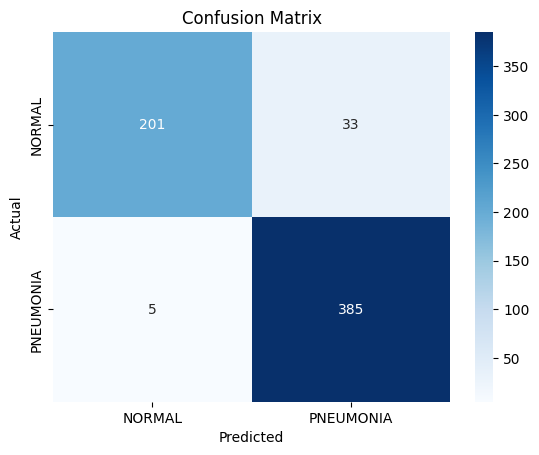

In [8]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


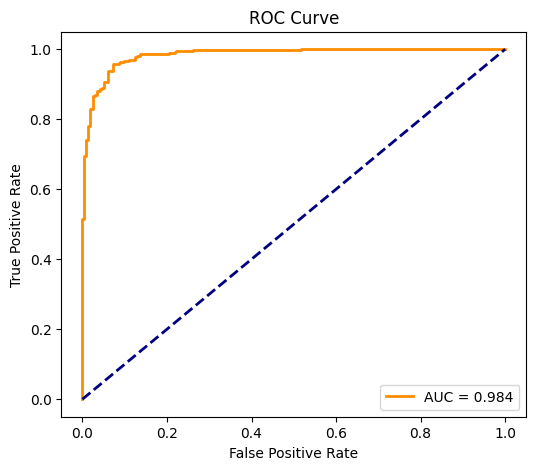

In [9]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

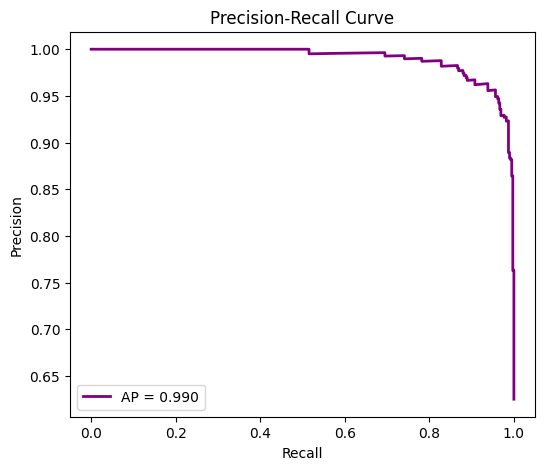

In [10]:
precision, recall, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f"AP = {ap:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [11]:
acc = (y_true == y_pred).mean() * 100
print(f"\nTest Accuracy: {acc:.2f}%")


Test Accuracy: 93.91%


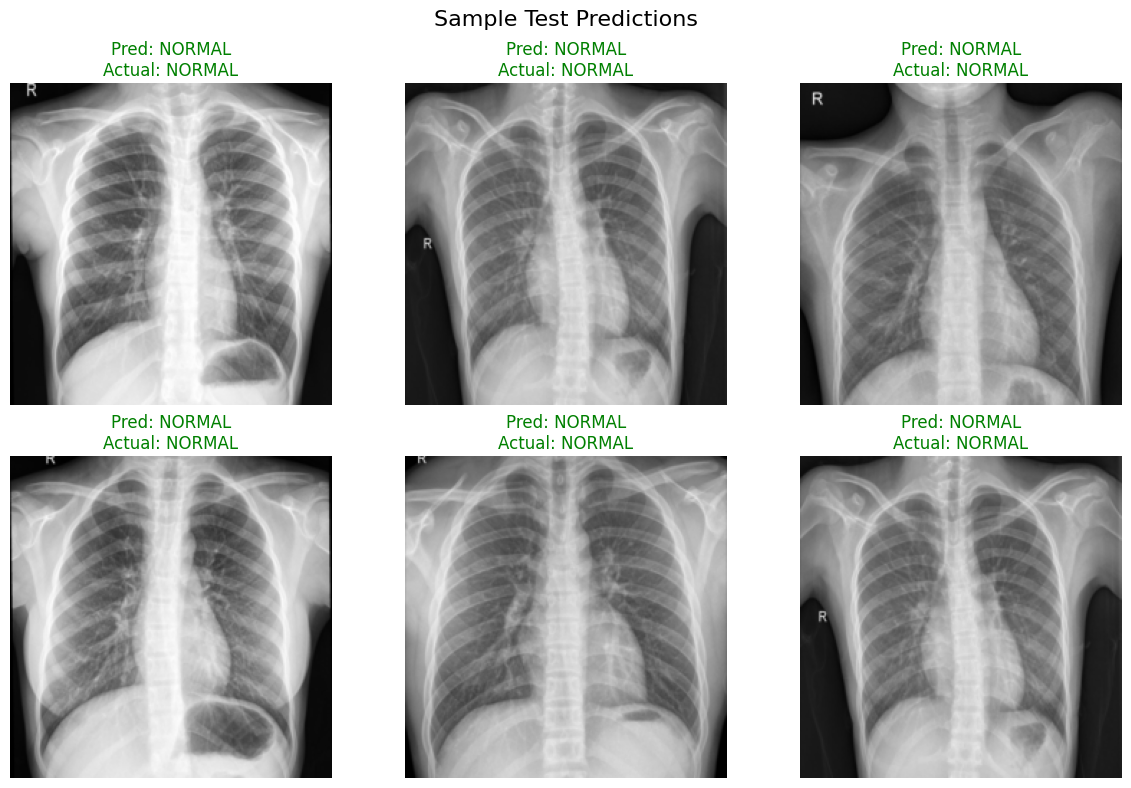

In [13]:
import random

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)


images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()


plt.figure(figsize=(12, 8))
for i in range(6):
    idx = random.randint(0, len(images) - 1)
    img = np.transpose(images[idx], (1, 2, 0))
    img = (img * 0.229) + 0.485  
    img = np.clip(img, 0, 1)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    color = "green" if preds[idx] == labels[idx] else "red"
    plt.title(f"Pred: {class_names[preds[idx]]}\nActual: {class_names[labels[idx]]}",
              color=color)
    plt.axis("off")

plt.suptitle("Sample Test Predictions", fontsize=16)
plt.tight_layout()
plt.show()